В данном блокноте мы рассмотрим генерацию изображений с помощью генеративно-состязательных сетей (GAN). Такая сеть состоит из генератора, который обучен, что понятно и из названия, генерировать данные, и дискриминатора, который сравнивает смоделированные данные с реальными.

Начнем с простого примера, который не требует большого количества времени для получения результатов. Попробуем сгенерировать предмет одежды, взяв в качестве исходных изображений коллекцию Fashion MNIST.

Импортируем библиотеки (мы будем использовать библиотеку PyTorch):


In [ ]:
import os
import numpy as np
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

"Зафиксируем случайность", чтобы наш эксперимент был воспроизводим.

In [ ]:
torch.manual_seed(111)

Тензоры могут находиться либо на процессоре, либо на графическом процессоре. Время обучения на процессоре (CPU) дольше, поэтому, если есть возможность, поместим тензоры на графический процессор:

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Определем функцию трансформации, которая преобразует данные в тензор PyTorch и нормализует их. В нашем примере этого достаточно, поскольку исходные изображения — это изображения в градациях серого, имеющие одинаковый размер.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Загружаем датасет. В нашем случае набор данных FashionMNIST можно загрузить непосредственно через соответсвующую встроенную библиотеку.

Одновременно трансформируем исходные данные в тензоры и нормализуем. Стоит отметить , что в функции трансформации мы учли, что в нашем случае используется только один канал, так как изображения являются черно-белыми.

In [ ]:
train_set = torchvision.datasets.FashionMNIST(
    root=".", train=True, download=True, transform=transform)


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Создаем "загрузчик" данных, который будет "паковать" их в соответсвии с указанным размером.

In [ ]:
batch_size = 32 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

Выведем исходные изображения для первого пакета:

In [ ]:
def display_samples(ds, row, col):
    ds_iter = iter(ds)
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0], cmap="gray_r")
    plt.show()

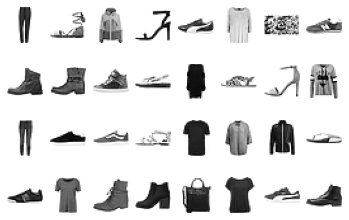

In [ ]:
display_samples(next(iter(train_loader))[0], 4, 8)

Создаем дискриминатор, который получает выборку из реальных данных (или от генератора) и выдает вероятность того, что выборка относится к реальным обучающим данным.

В качестве архитектуры нейросети используется многослойный перцептрон. Его структура послойно задается с помощью nn.Sequential().

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),     # 28X28 =  784
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
        
discriminator = Discriminator().to(device=device)

In [ ]:
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


Аналогично создаем класс генератора, наследуемый от nn.Module, определяем архитектуру нейронной сети, и, наконец, создаем экземпляр объекта Generator:

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [ ]:
print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


Определим количество эпох, скорость обучения. В качестве функции потерь выберем бинарную кросс-энтропию nn.BCELoss, а в качестве оптимизатора, стандартно, Adam.

In [ ]:
lr = 0.0001
num_epochs = 20
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Нашей модели на обучение для 20 эпох подтребуется около часа (зависит от настроек среды выполнения).

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Данные для тренировки дискриминатора
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))
        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)
        

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Показываем loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
torch.save(generator, '/content/generator_20')
torch.save(discriminator, '/content/discriminator_20')

Epoch: 0 Loss D.: 0.5229704976081848
Epoch: 0 Loss G.: 1.103852391242981
Epoch: 1 Loss D.: 0.5609273910522461
Epoch: 1 Loss G.: 1.0788958072662354
Epoch: 2 Loss D.: 0.6413915753364563
Epoch: 2 Loss G.: 0.9381518959999084
Epoch: 3 Loss D.: 0.6167370080947876
Epoch: 3 Loss G.: 1.1102654933929443
Epoch: 4 Loss D.: 0.6056671738624573
Epoch: 4 Loss G.: 0.9315968751907349
Epoch: 5 Loss D.: 0.5361199975013733
Epoch: 5 Loss G.: 0.9695902466773987
Epoch: 6 Loss D.: 0.508020281791687
Epoch: 6 Loss G.: 1.0132497549057007
Epoch: 7 Loss D.: 0.5666420459747314
Epoch: 7 Loss G.: 0.8645178079605103
Epoch: 8 Loss D.: 0.6963459849357605
Epoch: 8 Loss G.: 0.8945678472518921
Epoch: 9 Loss D.: 0.5758315324783325
Epoch: 9 Loss G.: 0.8808123469352722
Epoch: 10 Loss D.: 0.5981625914573669
Epoch: 10 Loss G.: 0.7738164067268372
Epoch: 11 Loss D.: 0.6163865327835083
Epoch: 11 Loss G.: 0.9131001234054565
Epoch: 12 Loss D.: 0.6087164282798767
Epoch: 12 Loss G.: 0.9208409786224365
Epoch: 13 Loss D.: 0.5969513654708

Генератор и дискриминатор сохранили на диске для возможности последующего использования.

Создадим тензор, заполненный произвольными числами, и сгенерируем на нем примеры нашей моделью:

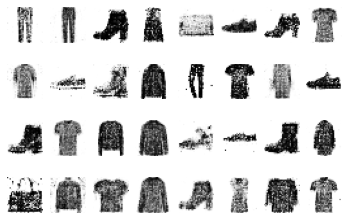

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()
display_samples(generated_samples, 4, 8)

Теперь рассмотрим другой пример — CycleGan. На входе у нас две коллекции — картины Оскара Моне и фотографии пейзажей. Мы хотим преобразовать фотографии в стиль картин Моне. В данном случае у нас непарные данные — картины и фотографии, несвязанные между собой.

В отличие от первой модели (GAN), сейчас мы будем генерировать изображение не из случайного шума, а из существующего изображения (фото пейзажа).

На обучение такой модели требуется достаточно много времени, поэтому мы воспользуемся предтренированной моделью и посмотрим, как она работает на новых данных.

Мы будем использовать подход, описанный в работе "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks" Jun-Yan Zhu, Taesung Park, Phillip Isola, Alexei A. Efros. Предобученная модель выложена на https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.

Клонируем репозиторий:

In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2337, done.
remote: Total 2337 (delta 0), reused 0 (delta 0), pack-reused 2337
Receiving objects: 100% (2337/2337), 8.09 MiB | 34.10 MiB/s, done.
Resolving deltas: 100% (1499/1499), done.


In [ ]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 686kB 19.2MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp37-none-any.whl size=655251 sha256=a807a0124243a58d7ea50362bc0640b9cef7092ffee131d8a3c14ca4ff02d30b
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp37-none-any.whl size=5713 sha256=a886756e2f631ab46981c3ee561e932e24508eac987339f13aaee256849d205e
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


Загружаем коллекции:

In [ ]:
!bash ./datasets/download_cyclegan_dataset.sh monet2photo

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./datasets/monet2photo/trainB/2016-03-31 05:58:36.jpg  
  inflating: ./datasets/monet2photo/trainB/2014-01-10 12:46:39.jpg  
  inflating: ./datasets/monet2photo/trainB/2015-02-23 11:45:00.jpg  
  inflating: ./datasets/monet2photo/trainB/2015-05-23 09:38:08.jpg  
  inflating: ./datasets/monet2photo/trainB/2016-01-15 00:48:49.jpg  
  inflating: ./datasets/monet2photo/trainB/2016-12-27 18:15:26.jpg  
  inflating: ./datasets/monet2photo/trainB/2017-01-02 11:16:05.jpg  
  inflating: ./datasets/monet2photo/trainB/2015-08-06 11:08:32.jpg  
  inflating: ./datasets/monet2photo/trainB/2015-12-16 07:43:36.jpg  
  inflating: ./datasets/monet2photo/trainB/2016-03-25 12:57:28.jpg  
  inflating: ./datasets/monet2photo/trainB/2016-05-10 11:44:44.jpg  
  inflating: ./datasets/monet2photo/trainB/2015-03-11 08:01:52.jpg  
  inflating: ./datasets/monet2photo/trainB/2015-08-30 05:26:05.jpg  
  inflating: ./datasets/monet2photo

Загружаем уже натренированную модель:

In [ ]:
!bash ./scripts/download_cyclegan_model.sh style_monet

Note: available models are apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower
Specified [style_monet]
for details.

--2021-05-05 09:04:11--  http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models/style_monet.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45575747 (43M)
Saving to: ‘./checkpoints/style_monet_pretrained/latest_net_G.pth’

./checkpoints/style 100%[===================>]  43.46M   918KB/s    in 27s     

2021-05-05 09:04:39 (1.60 MB/s) - ‘./checkpoints/style_monet_pretrained/latest_net_G.pth’ saved [45575747/45575747]



Коллекции, которые использовались для обучения модели, находятся в папке /content/pytorch-CycleGAN-and-pix2pix/datasets/monet2photo/. Добавим туда свою папку /testC/ с новыми фото, на которым мы посмотрим результаты работы модели.

In [ ]:
os.makedirs('/content/pytorch-CycleGAN-and-pix2pix/datasets/monet2photo/testC', exist_ok=True)

Тестируем модель:

In [ ]:
!python test.py --dataroot '/content/pytorch-CycleGAN-and-pix2pix/datasets/monet2photo/testC' --name style_monet_pretrained --model test  --no_dropout

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/pytorch-CycleGAN-and-pix2pix/datasets/monet2photo/testC	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_i

Смотрим на полученные результаты, которые находятся в папке /content/pytorch-CycleGAN-and-pix2pix/results/style_monet_pretrained/test_latest/images/ и имеют соответсвующие названия "fake" и "real".

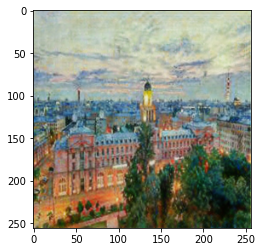

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread('/content/pytorch-CycleGAN-and-pix2pix/results/style_monet_pretrained/test_latest/images/ITMO_1_fake.png')
plt.imshow(img)

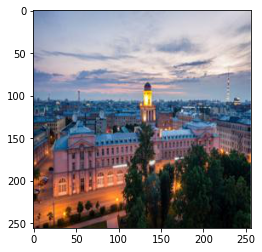

In [ ]:
img = plt.imread('/content/pytorch-CycleGAN-and-pix2pix/results/style_monet_pretrained/test_latest/images/ITMO_1_real.png')
plt.imshow(img)